<a href="https://colab.research.google.com/github/cgold212/assignment3inverseMethod/blob/main/Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3: Solving Helmholtz differental equations 

**Deadline**: 25.01.23

**Submission**: Submit a PDF export of the completed notebook as well as the ipynb file. 



In this assignment, we will build a Physics Informed Neural Networks (PINN) that can solve Helmholtz equation. The Helmholtz equation is a Partial Differential Equation (PDE) that arises to solve physical problems such as wave propogation. Its linear version takes the form of the  partial differential equation $∇^{2}h = -k^{2}h$, where $∇^{2}$ is the Laplace operator, $k$ is the wave number and $h$ is the function, where $h(x, z) = u(x, z) + iv(x, z)$


We will explore how leveraging data helps us to solve physics problems, in particular Helmholtz equation. We will use DNNs architectures and the boundary and initial conditions in the loss function,
a starter code is given to help with data processing and make it a bit easier.

In this assignment you have a chance to build your neural network all by yourself.

**Note:** you may modify the starter code as you see fit, including changing the signatures of functions and adding/removing helper functions. However, please make sure that you properly explain what you are doing and why.

In [89]:
import numpy as np
import torch
import torch.autograd as autograd         
from torch import Tensor                  
import random 

!pip install pyDOE
from pyDOE import lhs 
import torch.nn as nn                    
import torch.optim as optim         
import matplotlib.pyplot as plt
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [90]:
device

device(type='cuda')

## Question 1. Data (15%)

<!-- With any machine learning problem, the first thing that we would want to do
is to get an intuitive understanding of what our data looks like. Download the file
`??` from the course page on Moodle and upload it to Google Drive.
Then, mount Google Drive from your Google Colab notebook: -->
In this part you will generate a 2-D input dataset with a collection points that enforce the initial and boundary conditions.
Where the computational domain is $x ∈ [-1,1]$ and $z ∈ [0, 1]$.

We want to generate an input datasets which contain two aperture

Each of the datasets have 256 **equally** spaced spatial points to enforce the initial condition. 


In [91]:
"""
X with size (260, 260) and the size of each row is (256,) where each row is from -1 to 1 (i.e x0)
Z with size (260, 260) and the size of each column is (256,) where each column is from 0 to 1 (i.e. z0)
"""
initial_points = 256
half_aperture = 0.2
x0 = np.linspace(-1,1,initial_points)  # 256 points between -1 and 1 (260,)
z0 = np.linspace(0,1,initial_points)  # 256 points between 0 and 1 (260,)

X, Z = np.meshgrid(x0, z0) # (256, 256)

In [92]:
#  Z[10] 


### Part (a) -- 7%

Generate the initial condition at $z=0$ i.e. $\mathcal{u}(\mathcal{x},\mathcal{z}=0) = rect(\frac{z}{2 * HalfAperture})$.

Where the middle of each rectangular needs to be at the middle of each half.

**Note:** the initial condition needs to be **only** at the first place of the first dimension of the array 


In [93]:
Exact_u = np.zeros((initial_points, initial_points))
Exact_v = np.zeros((initial_points, initial_points))

In [94]:
from matplotlib.legend_handler import Rectangle
# Your code goes here 
middle1 = -0.5
middle2 = 0.5
Exact_u[:,0] = 2*(np.heaviside(x0-middle1+half_aperture,0.5) - np.heaviside(x0-middle1-half_aperture,0.5) + np.heaviside(x0-middle2+half_aperture,0.5) - np.heaviside(x0-middle2-half_aperture,0.5))
Exact_v[:,0] = 2*(np.heaviside(x0-middle1+half_aperture,0.5) - np.heaviside(x0-middle1-half_aperture,0.5) + np.heaviside(x0-middle2+half_aperture,0.5) - np.heaviside(x0-middle2-half_aperture,0.5))
# print(Exact_u[:,0])
# print(Exact_u[100,1])

Text(0.5, 1.0, 'Initial condition')

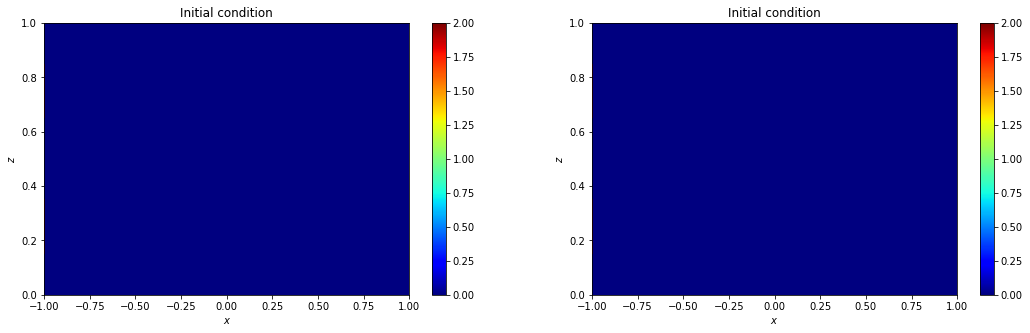

In [95]:
plt.figure(1, figsize=(18, 5))
plt.subplot(1, 2, 1)
plt.pcolor(x0, z0, Exact_u, cmap='jet')
plt.colorbar()
plt.xlabel(r'$x$', fontsize=10)
plt.ylabel(r'$z$', fontsize=10)
plt.title('Initial condition')
plt.subplot(1, 2, 2)
plt.pcolor(x0, z0, Exact_v, cmap='jet')
plt.colorbar()
plt.xlabel(r'$x$', fontsize=10)
plt.ylabel(r'$z$', fontsize=10)
plt.title('Initial condition')

In [96]:
U0 = Exact_u.copy()
V0 = Exact_v.copy()

u_true = U0.flatten('F')[:,None] 
v_true = V0.flatten('F')[:, None]

We prepare the test data to compare against the solution produced by the PINN.

In [97]:
X_u_test = np.hstack((X.flatten(order='F')[:,None], Z.flatten(order='F')[:,None]))
X_v_test = np.hstack((X.flatten(order='F')[:,None], Z.flatten(order='F')[:,None]))

# Domain bounds
lb = np.array([-1, 0]) #lower bound of x and z domains
ub = np.array([1, 1])  #upper bound of x and z domains
# print(X_u_test[256:256*2,:])

### Part (b) -- 8%

Now we want to generte a quasi-random point set object that produces points using Latin Hypercube sampling (LHS). 

Latin square is an $n \times n$ array filled with $n$ different symbols, each occurring exactly once in each row and exactly once in each column. A Latin hypercube is the generalization of this concept to an arbitrary number of dimensions where each sample is the **only** one in each axis of the hyperplane containing it.


You can start by reading [API documentation here](https://pythonhosted.org/pyDOE/randomized.html#latin-hypercube).


The function `generate_training_data` outputs the training data and the ground truth data, the output data is not normalized. 

In this part you will need to first to complete `X_f` in order to generate LHS for collection points. Second, reate a function `normalize_data` where the input is the data and the output is the normalized data. 

**Note:** You can modify the `generate_training_data` function so the output will be normalized data.


In [98]:
def generate_training_data(N_u, N_f, X, Z, usol):
    """
    X_f contains the samples inside to boundary condition
    X_f shape: (N_f, 2)
    Where (N_f, 0) and (N_f, 1) are the samples that maintain  x and z 
    boundary condition respectivly 
    """
    # Your code goes here        
    Xidx = np.linspace(0,255,initial_points)#np.random.choice(np.arange(X.shape[0]), size=N_u, replace=False)
    # print(Xidx.astype(int))
    Zidx = np.random.choice(np.arange(X.shape[0]), size=N_u, replace=False)
    X_u_train = np.array([X[1,Xidx.astype(int)],Z[Zidx,1]*0])
    X_u_train = X_u_train.T
    # print(X_u_train.shape)
    # print(X_u_train)
    u_train = usol[Xidx.astype(int),Zidx*0]

    # Latin Hypercube sampling for collocation points 
    X_f = lhs(2, N_f)
    X_f = X_f * np.array([X[1,:].max() - X[1,:].min(), Z[:,1].max() - Z[:,1].min()]) + np.array([X[1,:].min(), Z[:,1].min()])
    # X_u_train2 = X_u_train.reshape(N_u**2,2)
    # print(X_f.shape)
    # print(X_u_train2.shape)
    # print(X_u_train.shape)
    X_f_train = np.vstack((X_f, X_u_train)) # append training points to collocation points 
    # print(X_f_train.shape)
    return X_f_train, X_u_train, u_train 

Generate the training data, you can modify `N_f` and `N_u` in order to get better results.

**Remember the model inputs type need to be Torch and not numpy**

In [99]:
N_u = initial_points
N_f = 10000

# Training data
X_f_u_train, X_u_train, u_train = generate_training_data(N_u, N_f, X, Z, U0)
X_f_v_train, X_v_train, v_train = generate_training_data(N_u, N_f, X, Z, V0)
indices = np.where(X_f_u_train[:,1]==3)[0]
# print(len(indices))
# print(X_f_u_train[indices,:].shape)
print(np.min(X_u_train))

-1.0


## Question 2. Model architecture (30%)

**Note:** You can can train the the same model on $u(x, z)$ and $v(x, z)$ seperatly and combin the output of the two models or you can do it directly on $h(x, z)$. Where $|h(x, z)| = \sqrt{u(x, z)^{2} + v(x, z)^{2}}$.


### Part (a) -- 15%
Implement a PINN model architecture in PyTorch called `PINN` that will take the data points and will solve the Helmholtz equation.

It is recommended that the model will contain 9 hidden layers, start with this number and play with it. In assition, you can play with the number of in/out features of the hidden layers in order to get good results.

We build the model in PyTorch. Since PyTorch uses automatic
differentiation, we only need to write the *forward pass* of our
model. 


In [113]:
import torch.nn as nn
import torch.nn.init as init


class PINN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(PINN, self).__init__() #call __init__ from parent class 
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.bn3 = nn.BatchNorm1d(hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.bn4 = nn.BatchNorm1d(hidden_size)
        self.fc5 = nn.Linear(hidden_size, hidden_size)
        self.bn5 = nn.BatchNorm1d(hidden_size)
        self.fc6 = nn.Linear(hidden_size, hidden_size)
        self.bn6 = nn.BatchNorm1d(hidden_size)
        self.fc7 = nn.Linear(hidden_size, hidden_size)
        self.bn7 = nn.BatchNorm1d(hidden_size)
        self.fc8 = nn.Linear(hidden_size, hidden_size)
        self.bn8 = nn.BatchNorm1d(hidden_size)
        self.fc9 = nn.Linear(hidden_size, output_size)
        
        init.xavier_uniform_(self.fc1.weight)
        init.xavier_uniform_(self.fc2.weight)
        init.xavier_uniform_(self.fc3.weight)
        init.xavier_uniform_(self.fc4.weight)
        init.xavier_uniform_(self.fc5.weight)
        init.xavier_uniform_(self.fc6.weight)
        init.xavier_uniform_(self.fc7.weight)
        init.xavier_uniform_(self.fc8.weight)
        init.xavier_uniform_(self.fc9.weight)

        init.constant_(self.fc1.bias, 0)
        init.constant_(self.fc2.bias, 0)
        init.constant_(self.fc3.bias, 0)
        init.constant_(self.fc4.bias, 0)
        init.constant_(self.fc5.bias, 0)
        init.constant_(self.fc6.bias, 0)
        init.constant_(self.fc7.bias, 0)
        init.constant_(self.fc8.bias, 1)
        init.constant_(self.fc9.bias, 2)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = torch.relu(self.bn2(self.fc2(x)))
        x = torch.relu(self.bn3(self.fc3(x)))
        x = torch.relu(self.bn4(self.fc4(x)))
        x = torch.relu(self.bn5(self.fc5(x)))
        x = torch.relu(self.bn6(self.fc6(x)))
        x = torch.relu(self.bn7(self.fc7(x)))
        x = torch.relu(self.bn8(self.fc8(x)))
        x = torch.sigmoid(self.fc9(x))
        return x
    # def forward(self, x):
    #     # print(x.shape)
    #     x = torch.relu((self.fc1(x)))
    #     # print(x.shape)
    #     # x = torch.relu((self.fc2(x)))
    #     # x = torch.relu((self.fc3(x)))
    #     # x = torch.relu((self.fc4(x)))
    #     # x = torch.relu((self.fc5(x)))
    #     # x = torch.relu((self.fc6(x)))
    #     # x = torch.relu((self.fc7(x)))
    #     # x = torch.relu((self.fc8(x)))
    #     x = self.fc9(x)
    #     return x



In [101]:
# input_size = 2 # x,z coordinates
# hidden_size = 256
# output_size = 2 # u(x,z) uxx(x,z) uzz(x,z)
# model = PINN(input_size, hidden_size, output_size)

# batch_size = 10256
# data_loader = DataLoader(X_f_u_train, batch_size=batch_size, shuffle=True)
# for i, batch in enumerate(data_loader):
#   x = batch[:1,:]
#   break


# x = torch.tensor(x,dtype= torch.float32, requires_grad=True)
# print(x.shape)
# out = model(x)


# y = torch.autograd.grad(out, x, torch.ones(out.shape), create_graph=True, retain_graph=True)
# yx = torch.autograd.grad(y, x, torch.ones(out.shape), create_graph=True)
# print(y)
# print(yx)
# # # out.backward(torch.ones(out.shape, dtype=torch.float), retain_graph=True)
# # # print(out)
# # # first_derivative = autograd.grad(model(batch[:2,:])[0,0], batch[0,:], create_graph=True,allow_unused=True )[0]
# # print(111111111)
# # x.grad = torch.tensor(x.grad,dtype= torch.float32, requires_grad=True)
# # print(x)
# # out = model(x)
# # y = torch.autograd.functional.hessian(ooo,x)


# # print(hessian)

**Please show the model scheme here:**

### Part (b) -- 15%

In this part you will build the loss function which takes as input the model parameters $X$ and $Z$, the initial and boundary conditions $X0$, $Z0$ and $H0$ and return the loss with respect to the learnable parameters.

The model is trained by enforcing that given an input the output of the network fulfills the Helmholtz's equation, the boundary conditions, and the initial condition. 

**Remember:** the loss function of the model needs to be `nn.MSELoss()`, use it when you compute the loss.

In [118]:
def mse_loss_f(u_pred, v_pred, v_pred_xx_zz, u_pred_xx_zz):
                
  # Write your code here
  # print(111111)
  # print(u_pred_xx_zz.shape)
  resU = u_pred_xx_zz[:,0] + u_pred_xx_zz[:,1] + 100*u_pred
  resV = v_pred_xx_zz[:,0] + v_pred_xx_zz[:,1] + 100*v_pred

  resU = resU.pow(2)
  resV = resV.pow(2)
  res = resU + resV
  resU = torch.sqrt(resU)
  resV = torch.sqrt(resV)
  loss = nn.MSELoss()
  L1 = loss(resU,torch.zeros_like(resU))
  L2 = loss(resV,torch.zeros_like(resU))
  return L1+L2
  # return res.sum()

# def mse_loss_f(model, X, Z):
#     # Convert the indices to coordinates
#     # x, y = np.meshgrid(indices[:, 0], indices[:, 1])
#     coords = np.stack([X, Z], axis=-1)

#     # Reshape coordinates to be compatible with the model
#     coords = coords.reshape(-1, 2)
#     coords = torch.tensor(coords,dtype=torch.float)
#     coords = torch.nn.functional.normalize(coords + 1, p=2, dim=1, eps=1e-12, out=None)
#     # print(coords.shape)
#     # print(coords)
#     # Run the coordinates through the model
#     output = model(coords)
#     # print(output.shape)
#     Uoutput = output[:,0]
#     Voutput = output[:,1]

#     # Reshape the output to match the original shape of the indices
#     Uoutput = Uoutput.reshape(256, 256)
#     Voutput = Voutput.reshape(256, 256)

#     # Set the output as a torch tensor and set requires_grad to True
#     Uoutput = torch.tensor(Uoutput, dtype=torch.float, requires_grad=True)
#     Voutput = torch.tensor(Voutput, dtype=torch.float, requires_grad=True)

#     # Compute the gradient with respect to x and z coordinates
#     Uoutput.requiresGrad = True
#     Voutput.requiresGrad = True

#     # Compute the first gradient in the x direction
#     Ufirst_grad_x = torch.gradient(Uoutput, axis=0)[0]
#     Ufirst_grad_z = torch.gradient(Uoutput, axis=1)[0]
#     Vfirst_grad_x = torch.gradient(Voutput, axis=0)[0]
#     Vfirst_grad_z = torch.gradient(Voutput, axis=1)[0]

#     # Compute the second gradient in the x direction
#     Usecond_grad_x = torch.gradient(Ufirst_grad_x, axis=0)[0]
#     Usecond_grad_z = torch.gradient(Ufirst_grad_z, axis=1)[0]
#     Vsecond_grad_x = torch.gradient(Vfirst_grad_x, axis=0)[0]
#     Vsecond_grad_z = torch.gradient(Vfirst_grad_z, axis=1)[0]
    

#     # grad_x = grad_x[:, 0].reshape(256, 256)
#     # grad_z = grad_z[:, 1].reshape(256, 256)

#     resU = Usecond_grad_x + Usecond_grad_z  + Uoutput
#     resV = Vsecond_grad_x + Vsecond_grad_z  + Voutput
#     resU = resU.pow(2)
#     resV = resV.pow(2)
#     res = resU + resV
#     res = torch.sqrt(res)
#     loss = nn.MSELoss()
#     return loss(res,torch.zeros_like(res))



In [103]:
def mse_loss_h(v_pred, u_pred, Exact_u,Exact_v):
                
  # Write your code here
  loss = nn.MSELoss()
  u_pred = u_pred.pow(2)
  v_pred = v_pred.pow(2)
  h = u_pred + v_pred
  # print(h[0])

  return loss(Exact_u, torch.sqrt(h))

In [104]:
def mse_loss():
  # Write your code here
        
  return ...

## Question 3. Training (40%)

Now, we will write the functions required to train the PyTorch model using the `Adam optimizer` and the `mse loss` Q2-part (b). You can modify the optimizer parameters.

Keep in mind that our task is to solve the Helmholtz equation.

### Part (a) -- 30%

Complete the function `train_model`, and use it to train your PyTorch MLP model.

**Note:** You can change the `Adam` optimizer to whatever optimizer you want which gives a good results. 


In [120]:
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.init as init

# def xavier_init(model):
#     for name, param in model.named_parameters():
#         if "weight" in name:
#             init.xavier_uniform_(param)
#         elif "bias" in name:
#             init.constant_(param, 0)

# Create a data loader
batch_size = 10256
data_loader = DataLoader(X_f_u_train, batch_size=batch_size, shuffle=False)
# Define the network
input_size = 2 # x,z coordinates
hidden_size = 256
output_size = 2 # u(x,z) uxx(x,z) uzz(x,z)
model = PINN(input_size, hidden_size, output_size).to(device)

Exact_u = torch.tensor(Exact_u,dtype=torch.float).to(device)
Exact_v = torch.tensor(Exact_v,dtype=torch.float).to(device)

num_epochs = 50

optimizer = optim.Adam(model.parameters(), lr=5e-4, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-3, amsgrad=False)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99, last_epoch=-1)


def train_model(model, data_loader, num_epochs, mse_loss_f, mse_loss_h, optimizer):
  start_time = time.time()
  print('Training start time: %.2f' % (start_time))
  train_losses = []
  train_losses_iter = []
  n_iters = 0

  for epoch in range(num_epochs):
        
        # set training parameter
        model.train()
        train_loss = 0
        total_correct = 0
        total_instances = 0        
        n_iters = 0
        if epoch % 10 == 0:
          scheduler.step()
          plot_model_output(trained_model,X_u_test,x0, z0)
          # if epoch == 200 :
          #   optimizer = optim.Adam(model.parameters(), lr=1e-5, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5, amsgrad=False)

        # Iterate over batches
        for i, batch in enumerate(data_loader):
          n_iters += 1
          optimizer.zero_grad()
          indices = np.where(batch[:,1]==0)[0]
          np_batch = batch[indices,0].detach().numpy()
          idx = np.array([])
          for n in range(len(indices)):
            idx = np.append(idx,np.where( X[0,:]== np_batch[n]))
            # print(len(indices))
          # batch = torch.nn.functional.normalize(batch + 1, p=2, dim=1, eps=1e-12, out=None)
          batch = torch.tensor(batch,dtype=torch.float32, requires_grad=True).to(device)
          # print(batch.shape)

          temp = model(batch)
          v_pred = temp[:,1]
          u_pred = temp[:,0]
          v_pred_x_z = torch.autograd.grad(v_pred, batch, torch.ones(v_pred.shape).to(device), create_graph=True, retain_graph=True)
          v_pred_x_z = torch.cat(v_pred_x_z,0)
          v_pred_xx_zz = torch.autograd.grad(v_pred_x_z, batch, torch.ones(v_pred_x_z.shape).to(device), create_graph=True)
          v_pred_xx_zz = torch.cat(v_pred_xx_zz,0)
          u_pred_x_z = torch.autograd.grad(u_pred, batch, torch.ones(u_pred.shape).to(device), create_graph=True, retain_graph=True)
          u_pred_x_z = torch.cat(u_pred_x_z,0)
          u_pred_xx_zz = torch.autograd.grad(u_pred_x_z, batch, torch.ones(u_pred_x_z.shape).to(device), create_graph=True)
          u_pred_xx_zz = torch.cat(u_pred_xx_zz,0)

          optimizer.zero_grad()

          if n_iters % 1 == 0:
            print('Iter - %d '%(n_iters))
            print('batch' , batch[0,:])
            print('grad',u_pred_xx_zz[0,:],u_pred[0])
            # print(u_pred.shape)
            print('u side',u_pred_xx_zz[0,0] + u_pred_xx_zz[0,1] + u_pred[0])

          
          
          # uzz_pred = temp[:,2]
          if len(indices):
            loss_f = mse_loss_f(u_pred, v_pred, v_pred_xx_zz, u_pred_xx_zz)
            indices = torch.tensor(indices,dtype=torch.int).numpy()
            idx = torch.tensor(idx,dtype=torch.int).numpy()
            # print(torch.unsqueeze(Exact_u[idx,0],1).shape)
            # print(torch.cat((torch.unsqueeze(Exact_u[idx,0],1),torch.unsqueeze(u_pred[indices],1)),1))
            # print(u_pred[indices].shape)
            loss_h = mse_loss_h(v_pred[indices], u_pred[indices], Exact_u[idx,0],Exact_v[idx,0])
            # alpha = 0.9 #loss_h/(loss_f+loss_h)*epoch/num_epochs
            alpha = loss_f/(loss_f+loss_h)
            # print('alpha- %5f'%(alpha))
            print('insid',((alpha)*loss_f)*1e4)
            print('bound',(1-alpha)*loss_h*1e4)
            loss = ((1-alpha)*loss_h + (alpha)*loss_f)*1e4
          else:
            loss = mse_loss_f(u_pred, v_pred, v_pred_xx_zz, u_pred_xx_zz)
            
          loss.backward() 
          optimizer.step()
          train_loss += loss.item()
          train_losses_iter.append(loss.item()/data_loader.batch_size)
          if n_iters % 1 == 0:
            print('Iter - %d Train loss - %f'%(epoch , loss.item()/data_loader.batch_size))

  # Write your code here
  
  elapsed = time.time() - start_time
  print('Training end time: %.2f, Training time: %.2f' % (time.time(), elapsed))
  return train_losses_iter, model


<ipython-input-120-4e4744fb539b>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Exact_u = torch.tensor(Exact_u,dtype=torch.float).to(device)
<ipython-input-120-4e4744fb539b>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Exact_v = torch.tensor(Exact_v,dtype=torch.float).to(device)


Training start time: 1675409395.32


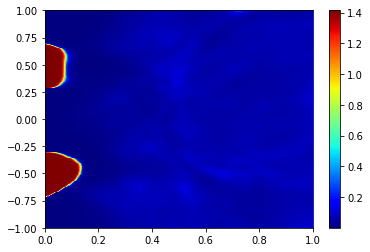

<ipython-input-120-4e4744fb539b>:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = torch.tensor(batch,dtype=torch.float32, requires_grad=True).to(device)


Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([-2.2702e-06,  5.3919e-06], device='cuda:0', grad_fn=<SliceBackward0>) tensor(0.9733, device='cuda:0', grad_fn=<SelectBackward0>)
u side tensor(0.9733, device='cuda:0', grad_fn=<AddBackward0>)
insid tensor(1.4764e+08, device='cuda:0', grad_fn=<MulBackward0>)
bound tensor(0.7902, device='cuda:0', grad_fn=<MulBackward0>)
Iter - 0 Train loss - 14395.396256
Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([-1.5196e-06,  3.1548e-06], device='cuda:0', grad_fn=<SliceBackward0>) tensor(0.9905, device='cuda:0', grad_fn=<SelectBackward0>)
u side tensor(0.9905, device='cuda:0', grad_fn=<AddBackward0>)
insid tensor(1.2680e+08, device='cuda:0', grad_fn=<MulBackward0>)
bound tensor(0.7413, device='cuda:0', grad_fn=<MulBackward0>)
Iter - 1 Train loss - 12363.379095
Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor(

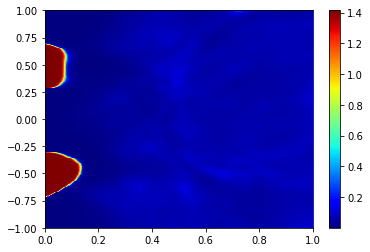

Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([-8.8046e-07,  3.1866e-06], device='cuda:0', grad_fn=<SliceBackward0>) tensor(0.9907, device='cuda:0', grad_fn=<SelectBackward0>)
u side tensor(0.9907, device='cuda:0', grad_fn=<AddBackward0>)
insid tensor(56912520., device='cuda:0', grad_fn=<MulBackward0>)
bound tensor(1.6385, device='cuda:0', grad_fn=<MulBackward0>)
Iter - 10 Train loss - 5549.192668
Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([ 3.0158e-07, -1.3726e-06], device='cuda:0', grad_fn=<SliceBackward0>) tensor(0.9666, device='cuda:0', grad_fn=<SelectBackward0>)
u side tensor(0.9666, device='cuda:0', grad_fn=<AddBackward0>)
insid tensor(53441644., device='cuda:0', grad_fn=<MulBackward0>)
bound tensor(1.8599, device='cuda:0', grad_fn=<MulBackward0>)
Iter - 11 Train loss - 5210.768721
Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([1

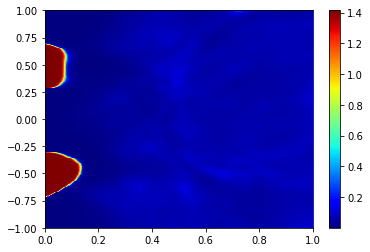

Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([7.2274e-07, 3.7317e-07], device='cuda:0', grad_fn=<SliceBackward0>) tensor(0.1785, device='cuda:0', grad_fn=<SelectBackward0>)
u side tensor(0.1785, device='cuda:0', grad_fn=<AddBackward0>)
insid tensor(33896960., device='cuda:0', grad_fn=<MulBackward0>)
bound tensor(5.4054, device='cuda:0', grad_fn=<MulBackward0>)
Iter - 20 Train loss - 3305.086193
Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([ 2.5268e-06, -2.7008e-06], device='cuda:0', grad_fn=<SliceBackward0>) tensor(0.1716, device='cuda:0', grad_fn=<SelectBackward0>)
u side tensor(0.1716, device='cuda:0', grad_fn=<AddBackward0>)
insid tensor(32586424., device='cuda:0', grad_fn=<MulBackward0>)
bound tensor(5.7113, device='cuda:0', grad_fn=<MulBackward0>)
Iter - 21 Train loss - 3177.303822
Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([6.4

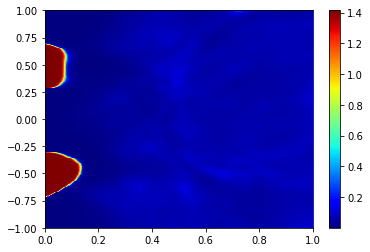

Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([ 3.2649e-06, -1.0223e-06], device='cuda:0', grad_fn=<SliceBackward0>) tensor(0.1846, device='cuda:0', grad_fn=<SelectBackward0>)
u side tensor(0.1846, device='cuda:0', grad_fn=<AddBackward0>)
insid tensor(22564712., device='cuda:0', grad_fn=<MulBackward0>)
bound tensor(8.6226, device='cuda:0', grad_fn=<MulBackward0>)
Iter - 30 Train loss - 2200.148401
Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([ 1.1731e-06, -3.5548e-07], device='cuda:0', grad_fn=<SliceBackward0>) tensor(0.2058, device='cuda:0', grad_fn=<SelectBackward0>)
u side tensor(0.2058, device='cuda:0', grad_fn=<AddBackward0>)
insid tensor(21557520., device='cuda:0', grad_fn=<MulBackward0>)
bound tensor(9.0785, device='cuda:0', grad_fn=<MulBackward0>)
Iter - 31 Train loss - 2101.943253
Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([-

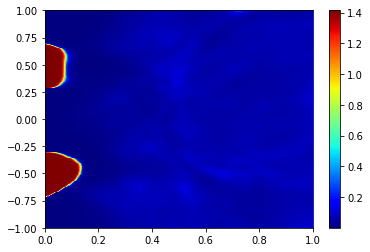

Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([ 5.9993e-07, -1.4799e-06], device='cuda:0', grad_fn=<SliceBackward0>) tensor(0.1515, device='cuda:0', grad_fn=<SelectBackward0>)
u side tensor(0.1515, device='cuda:0', grad_fn=<AddBackward0>)
insid tensor(14363516., device='cuda:0', grad_fn=<MulBackward0>)
bound tensor(12.4253, device='cuda:0', grad_fn=<MulBackward0>)
Iter - 40 Train loss - 1400.500000
Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([7.7680e-07, 1.1391e-06], device='cuda:0', grad_fn=<SliceBackward0>) tensor(0.1368, device='cuda:0', grad_fn=<SelectBackward0>)
u side tensor(0.1368, device='cuda:0', grad_fn=<AddBackward0>)
insid tensor(13602311., device='cuda:0', grad_fn=<MulBackward0>)
bound tensor(12.9903, device='cuda:0', grad_fn=<MulBackward0>)
Iter - 41 Train loss - 1326.279641
Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([-

In [121]:
train_losses, trained_model = train_model(model, data_loader, num_epochs, mse_loss_f, mse_loss_h, optimizer)

Training start time: 1675409201.38


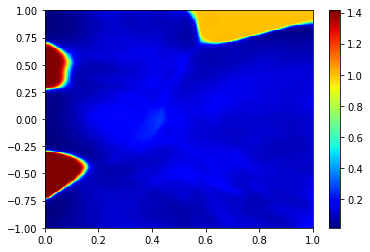

<ipython-input-115-4a308dbbd5f4>:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = torch.tensor(batch,dtype=torch.float32, requires_grad=True).to(device)


Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([-2.7606e-06,  5.8300e-07], device='cuda:0', grad_fn=<SliceBackward0>) tensor(1., device='cuda:0', grad_fn=<SelectBackward0>)
u side tensor(1.0000, device='cuda:0', grad_fn=<AddBackward0>)
insid tensor(557.1486, device='cuda:0', grad_fn=<MulBackward0>)
bound tensor(1044.4961, device='cuda:0', grad_fn=<MulBackward0>)
Iter - 0 Train loss - 0.156167
Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([-2.5203e-06,  9.0634e-07], device='cuda:0', grad_fn=<SliceBackward0>) tensor(1., device='cuda:0', grad_fn=<SelectBackward0>)
u side tensor(1.0000, device='cuda:0', grad_fn=<AddBackward0>)
insid tensor(203.2329, device='cuda:0', grad_fn=<MulBackward0>)
bound tensor(7886.1909, device='cuda:0', grad_fn=<MulBackward0>)
Iter - 1 Train loss - 0.788750
Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([-9.4513e-06, 

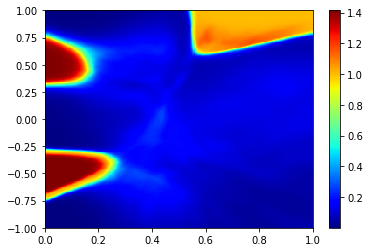

Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([-1.2728e-06,  2.8540e-07], device='cuda:0', grad_fn=<SliceBackward0>) tensor(1., device='cuda:0', grad_fn=<SelectBackward0>)
u side tensor(1.0000, device='cuda:0', grad_fn=<AddBackward0>)
insid tensor(921.8127, device='cuda:0', grad_fn=<MulBackward0>)
bound tensor(1401.9474, device='cuda:0', grad_fn=<MulBackward0>)
Iter - 10 Train loss - 0.226576
Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([-2.4318e-07,  7.6431e-08], device='cuda:0', grad_fn=<SliceBackward0>) tensor(1., device='cuda:0', grad_fn=<SelectBackward0>)
u side tensor(1.0000, device='cuda:0', grad_fn=<AddBackward0>)
insid tensor(895.1360, device='cuda:0', grad_fn=<MulBackward0>)
bound tensor(1315.7625, device='cuda:0', grad_fn=<MulBackward0>)
Iter - 11 Train loss - 0.215571
Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([-6.4921e-07

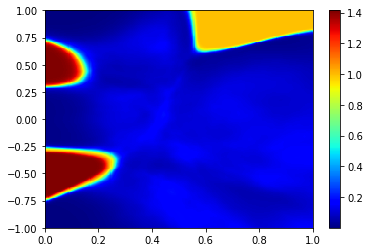

Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([-1.8797e-07, -2.0771e-07], device='cuda:0', grad_fn=<SliceBackward0>) tensor(1., device='cuda:0', grad_fn=<SelectBackward0>)
u side tensor(1.0000, device='cuda:0', grad_fn=<AddBackward0>)
insid tensor(927.4880, device='cuda:0', grad_fn=<MulBackward0>)
bound tensor(1057.2920, device='cuda:0', grad_fn=<MulBackward0>)
Iter - 20 Train loss - 0.193524
Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([4.4462e-09, 3.7767e-07], device='cuda:0', grad_fn=<SliceBackward0>) tensor(1., device='cuda:0', grad_fn=<SelectBackward0>)
u side tensor(1.0000, device='cuda:0', grad_fn=<AddBackward0>)
insid tensor(921.9990, device='cuda:0', grad_fn=<MulBackward0>)
bound tensor(969.2885, device='cuda:0', grad_fn=<MulBackward0>)
Iter - 21 Train loss - 0.184408
Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([-5.6083e-07,  

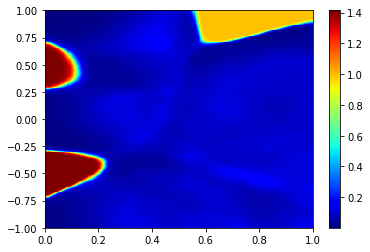

Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([ 8.5226e-07, -5.5286e-07], device='cuda:0', grad_fn=<SliceBackward0>) tensor(1., device='cuda:0', grad_fn=<SelectBackward0>)
u side tensor(1.0000, device='cuda:0', grad_fn=<AddBackward0>)
insid tensor(693.6155, device='cuda:0', grad_fn=<MulBackward0>)
bound tensor(907.1702, device='cuda:0', grad_fn=<MulBackward0>)
Iter - 30 Train loss - 0.156083
Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([ 1.4601e-07, -4.5693e-07], device='cuda:0', grad_fn=<SliceBackward0>) tensor(1., device='cuda:0', grad_fn=<SelectBackward0>)
u side tensor(1.0000, device='cuda:0', grad_fn=<AddBackward0>)
insid tensor(660.5288, device='cuda:0', grad_fn=<MulBackward0>)
bound tensor(946.7685, device='cuda:0', grad_fn=<MulBackward0>)
Iter - 31 Train loss - 0.156718
Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([-2.5117e-06, 

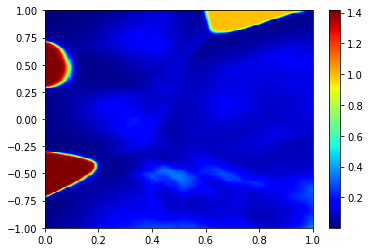

Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([ 1.4106e-05, -1.3560e-05], device='cuda:0', grad_fn=<SliceBackward0>) tensor(1., device='cuda:0', grad_fn=<SelectBackward0>)
u side tensor(1.0000, device='cuda:0', grad_fn=<AddBackward0>)
insid tensor(463.2062, device='cuda:0', grad_fn=<MulBackward0>)
bound tensor(922.5497, device='cuda:0', grad_fn=<MulBackward0>)
Iter - 40 Train loss - 0.135117
Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([1.8045e-06, 2.2653e-06], device='cuda:0', grad_fn=<SliceBackward0>) tensor(1., device='cuda:0', grad_fn=<SelectBackward0>)
u side tensor(1.0000, device='cuda:0', grad_fn=<AddBackward0>)
insid tensor(437.9988, device='cuda:0', grad_fn=<MulBackward0>)
bound tensor(951.0275, device='cuda:0', grad_fn=<MulBackward0>)
Iter - 41 Train loss - 0.135435
Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([-1.2915e-05,  7

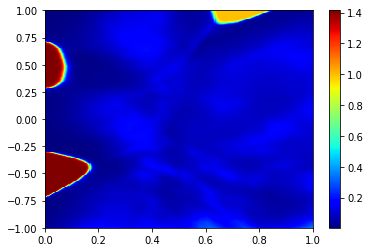

Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([ 2.5413e-05, -2.1716e-05], device='cuda:0', grad_fn=<SliceBackward0>) tensor(0.9998, device='cuda:0', grad_fn=<SelectBackward0>)
u side tensor(0.9998, device='cuda:0', grad_fn=<AddBackward0>)
insid tensor(316.2801, device='cuda:0', grad_fn=<MulBackward0>)
bound tensor(972.1466, device='cuda:0', grad_fn=<MulBackward0>)
Iter - 50 Train loss - 0.125627
Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([ 5.5896e-05, -4.9953e-05], device='cuda:0', grad_fn=<SliceBackward0>) tensor(0.9932, device='cuda:0', grad_fn=<SelectBackward0>)
u side tensor(0.9932, device='cuda:0', grad_fn=<AddBackward0>)
insid tensor(307.6256, device='cuda:0', grad_fn=<MulBackward0>)
bound tensor(964.2925, device='cuda:0', grad_fn=<MulBackward0>)
Iter - 51 Train loss - 0.124017
Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([ 0.00

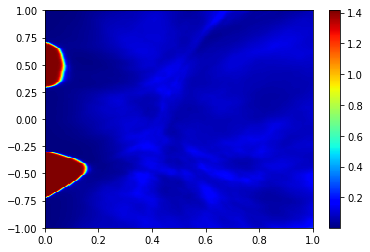

Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([ 1.5761e-06, -3.9680e-07], device='cuda:0', grad_fn=<SliceBackward0>) tensor(0.0038, device='cuda:0', grad_fn=<SelectBackward0>)
u side tensor(0.0038, device='cuda:0', grad_fn=<AddBackward0>)
insid tensor(212.0193, device='cuda:0', grad_fn=<MulBackward0>)
bound tensor(1148.0540, device='cuda:0', grad_fn=<MulBackward0>)
Iter - 60 Train loss - 0.132612
Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([ 7.9871e-07, -9.9802e-08], device='cuda:0', grad_fn=<SliceBackward0>) tensor(0.0036, device='cuda:0', grad_fn=<SelectBackward0>)
u side tensor(0.0036, device='cuda:0', grad_fn=<AddBackward0>)
insid tensor(247.7684, device='cuda:0', grad_fn=<MulBackward0>)
bound tensor(978.8094, device='cuda:0', grad_fn=<MulBackward0>)
Iter - 61 Train loss - 0.119596
Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([ 6.4

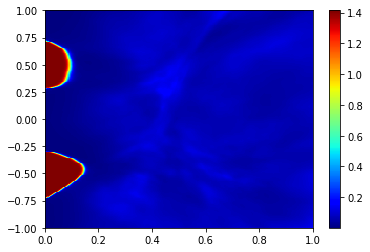

Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([ 1.4784e-06, -1.0054e-06], device='cuda:0', grad_fn=<SliceBackward0>) tensor(0.0052, device='cuda:0', grad_fn=<SelectBackward0>)
u side tensor(0.0052, device='cuda:0', grad_fn=<AddBackward0>)
insid tensor(247.7209, device='cuda:0', grad_fn=<MulBackward0>)
bound tensor(1031.4580, device='cuda:0', grad_fn=<MulBackward0>)
Iter - 70 Train loss - 0.124725
Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([ 1.2011e-06, -6.7106e-07], device='cuda:0', grad_fn=<SliceBackward0>) tensor(0.0056, device='cuda:0', grad_fn=<SelectBackward0>)
u side tensor(0.0056, device='cuda:0', grad_fn=<AddBackward0>)
insid tensor(238.9260, device='cuda:0', grad_fn=<MulBackward0>)
bound tensor(1043.5677, device='cuda:0', grad_fn=<MulBackward0>)
Iter - 71 Train loss - 0.125048
Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([ 8.

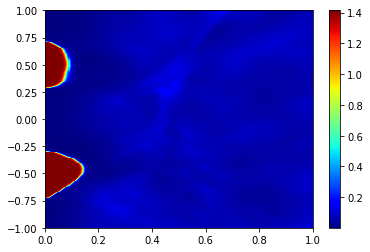

Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([ 2.7615e-07, -3.2921e-08], device='cuda:0', grad_fn=<SliceBackward0>) tensor(0.0087, device='cuda:0', grad_fn=<SelectBackward0>)
u side tensor(0.0087, device='cuda:0', grad_fn=<AddBackward0>)
insid tensor(228.5303, device='cuda:0', grad_fn=<MulBackward0>)
bound tensor(1092.0299, device='cuda:0', grad_fn=<MulBackward0>)
Iter - 80 Train loss - 0.128760
Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([-2.8863e-07,  2.9716e-07], device='cuda:0', grad_fn=<SliceBackward0>) tensor(0.0095, device='cuda:0', grad_fn=<SelectBackward0>)
u side tensor(0.0095, device='cuda:0', grad_fn=<AddBackward0>)
insid tensor(195.4761, device='cuda:0', grad_fn=<MulBackward0>)
bound tensor(1309.5713, device='cuda:0', grad_fn=<MulBackward0>)
Iter - 81 Train loss - 0.146748
Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([5.1

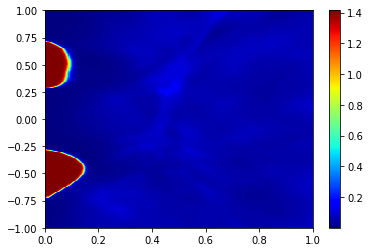

Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([ 7.0642e-07, -8.7303e-07], device='cuda:0', grad_fn=<SliceBackward0>) tensor(0.0104, device='cuda:0', grad_fn=<SelectBackward0>)
u side tensor(0.0104, device='cuda:0', grad_fn=<AddBackward0>)
insid tensor(241.3916, device='cuda:0', grad_fn=<MulBackward0>)
bound tensor(1142.7181, device='cuda:0', grad_fn=<MulBackward0>)
Iter - 90 Train loss - 0.134956
Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([ 7.7752e-07, -5.0956e-07], device='cuda:0', grad_fn=<SliceBackward0>) tensor(0.0113, device='cuda:0', grad_fn=<SelectBackward0>)
u side tensor(0.0113, device='cuda:0', grad_fn=<AddBackward0>)
insid tensor(236.2533, device='cuda:0', grad_fn=<MulBackward0>)
bound tensor(1071.4191, device='cuda:0', grad_fn=<MulBackward0>)
Iter - 91 Train loss - 0.127503
Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([ 2.

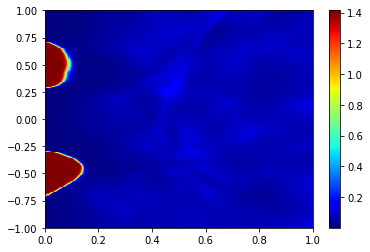

Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([-4.4673e-07,  3.9483e-07], device='cuda:0', grad_fn=<SliceBackward0>) tensor(0.0150, device='cuda:0', grad_fn=<SelectBackward0>)
u side tensor(0.0150, device='cuda:0', grad_fn=<AddBackward0>)
insid tensor(218.5261, device='cuda:0', grad_fn=<MulBackward0>)
bound tensor(1095.7446, device='cuda:0', grad_fn=<MulBackward0>)
Iter - 100 Train loss - 0.128147
Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([ 1.0729e-06, -7.1550e-07], device='cuda:0', grad_fn=<SliceBackward0>) tensor(0.0158, device='cuda:0', grad_fn=<SelectBackward0>)
u side tensor(0.0158, device='cuda:0', grad_fn=<AddBackward0>)
insid tensor(230.5943, device='cuda:0', grad_fn=<MulBackward0>)
bound tensor(1056.3181, device='cuda:0', grad_fn=<MulBackward0>)
Iter - 101 Train loss - 0.125479
Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([ 

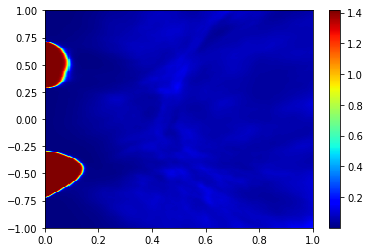

Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([2.7317e-07, 1.8403e-07], device='cuda:0', grad_fn=<SliceBackward0>) tensor(0.0174, device='cuda:0', grad_fn=<SelectBackward0>)
u side tensor(0.0174, device='cuda:0', grad_fn=<AddBackward0>)
insid tensor(233.8610, device='cuda:0', grad_fn=<MulBackward0>)
bound tensor(1009.5944, device='cuda:0', grad_fn=<MulBackward0>)
Iter - 110 Train loss - 0.121242
Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([ 2.4971e-06, -1.4616e-06], device='cuda:0', grad_fn=<SliceBackward0>) tensor(0.0196, device='cuda:0', grad_fn=<SelectBackward0>)
u side tensor(0.0196, device='cuda:0', grad_fn=<AddBackward0>)
insid tensor(221.8500, device='cuda:0', grad_fn=<MulBackward0>)
bound tensor(1018.0859, device='cuda:0', grad_fn=<MulBackward0>)
Iter - 111 Train loss - 0.120899
Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([-3.

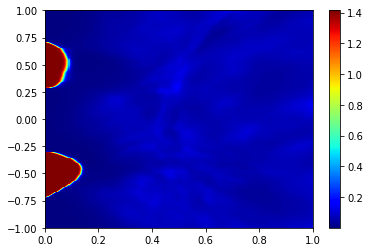

Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([-1.6596e-07,  5.8637e-07], device='cuda:0', grad_fn=<SliceBackward0>) tensor(0.0226, device='cuda:0', grad_fn=<SelectBackward0>)
u side tensor(0.0226, device='cuda:0', grad_fn=<AddBackward0>)
insid tensor(222.0425, device='cuda:0', grad_fn=<MulBackward0>)
bound tensor(974.2762, device='cuda:0', grad_fn=<MulBackward0>)
Iter - 120 Train loss - 0.116646
Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([ 2.8274e-07, -1.9200e-07], device='cuda:0', grad_fn=<SliceBackward0>) tensor(0.0239, device='cuda:0', grad_fn=<SelectBackward0>)
u side tensor(0.0239, device='cuda:0', grad_fn=<AddBackward0>)
insid tensor(214.5584, device='cuda:0', grad_fn=<MulBackward0>)
bound tensor(1000.7543, device='cuda:0', grad_fn=<MulBackward0>)
Iter - 121 Train loss - 0.118498
Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([ 7

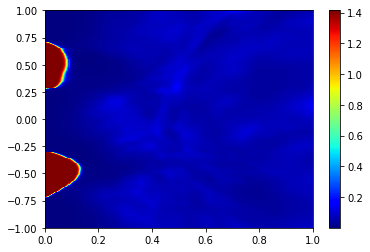

Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([-8.7983e-08,  8.5555e-08], device='cuda:0', grad_fn=<SliceBackward0>) tensor(0.0287, device='cuda:0', grad_fn=<SelectBackward0>)
u side tensor(0.0287, device='cuda:0', grad_fn=<AddBackward0>)
insid tensor(207.0917, device='cuda:0', grad_fn=<MulBackward0>)
bound tensor(1046.9037, device='cuda:0', grad_fn=<MulBackward0>)
Iter - 130 Train loss - 0.122269
Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([-5.1695e-07,  5.1891e-07], device='cuda:0', grad_fn=<SliceBackward0>) tensor(0.0287, device='cuda:0', grad_fn=<SelectBackward0>)
u side tensor(0.0287, device='cuda:0', grad_fn=<AddBackward0>)
insid tensor(210.3181, device='cuda:0', grad_fn=<MulBackward0>)
bound tensor(1110.4330, device='cuda:0', grad_fn=<MulBackward0>)
Iter - 131 Train loss - 0.128778
Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([ 

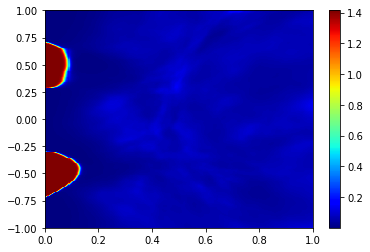

Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([ 3.8423e-07, -6.7135e-07], device='cuda:0', grad_fn=<SliceBackward0>) tensor(0.0309, device='cuda:0', grad_fn=<SelectBackward0>)
u side tensor(0.0309, device='cuda:0', grad_fn=<AddBackward0>)
insid tensor(216.4764, device='cuda:0', grad_fn=<MulBackward0>)
bound tensor(997.0323, device='cuda:0', grad_fn=<MulBackward0>)
Iter - 140 Train loss - 0.118322
Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([-2.0948e-06,  2.8080e-06], device='cuda:0', grad_fn=<SliceBackward0>) tensor(0.0303, device='cuda:0', grad_fn=<SelectBackward0>)
u side tensor(0.0303, device='cuda:0', grad_fn=<AddBackward0>)
insid tensor(218.5003, device='cuda:0', grad_fn=<MulBackward0>)
bound tensor(1058.2607, device='cuda:0', grad_fn=<MulBackward0>)
Iter - 141 Train loss - 0.124489
Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([-7

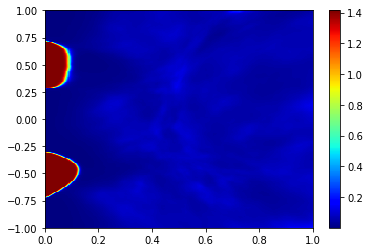

Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([-7.1046e-07,  7.5986e-07], device='cuda:0', grad_fn=<SliceBackward0>) tensor(0.0317, device='cuda:0', grad_fn=<SelectBackward0>)
u side tensor(0.0317, device='cuda:0', grad_fn=<AddBackward0>)
insid tensor(207.4319, device='cuda:0', grad_fn=<MulBackward0>)
bound tensor(1152.3597, device='cuda:0', grad_fn=<MulBackward0>)
Iter - 150 Train loss - 0.132585
Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([-1.9295e-06,  1.6328e-06], device='cuda:0', grad_fn=<SliceBackward0>) tensor(0.0296, device='cuda:0', grad_fn=<SelectBackward0>)
u side tensor(0.0296, device='cuda:0', grad_fn=<AddBackward0>)
insid tensor(203.0812, device='cuda:0', grad_fn=<MulBackward0>)
bound tensor(1148.0341, device='cuda:0', grad_fn=<MulBackward0>)
Iter - 151 Train loss - 0.131739
Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([ 

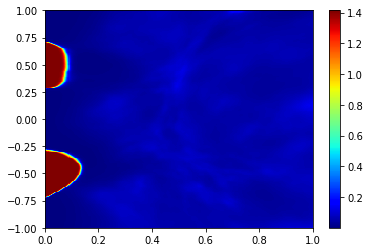

Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([ 1.3884e-07, -4.9656e-07], device='cuda:0', grad_fn=<SliceBackward0>) tensor(0.0271, device='cuda:0', grad_fn=<SelectBackward0>)
u side tensor(0.0271, device='cuda:0', grad_fn=<AddBackward0>)
insid tensor(219.9057, device='cuda:0', grad_fn=<MulBackward0>)
bound tensor(1072.0309, device='cuda:0', grad_fn=<MulBackward0>)
Iter - 160 Train loss - 0.125969
Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([ 1.5567e-06, -1.1989e-06], device='cuda:0', grad_fn=<SliceBackward0>) tensor(0.0290, device='cuda:0', grad_fn=<SelectBackward0>)
u side tensor(0.0290, device='cuda:0', grad_fn=<AddBackward0>)
insid tensor(221.3367, device='cuda:0', grad_fn=<MulBackward0>)
bound tensor(1012.6060, device='cuda:0', grad_fn=<MulBackward0>)
Iter - 161 Train loss - 0.120314
Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([ 

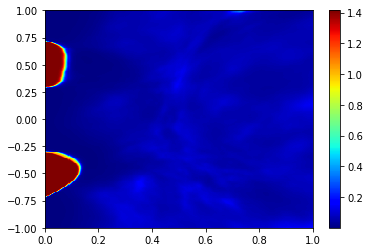

Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([ 5.0844e-07, -1.4724e-07], device='cuda:0', grad_fn=<SliceBackward0>) tensor(0.0397, device='cuda:0', grad_fn=<SelectBackward0>)
u side tensor(0.0397, device='cuda:0', grad_fn=<AddBackward0>)
insid tensor(200.1054, device='cuda:0', grad_fn=<MulBackward0>)
bound tensor(1106.3475, device='cuda:0', grad_fn=<MulBackward0>)
Iter - 170 Train loss - 0.127384
Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([ 3.4795e-06, -2.6905e-06], device='cuda:0', grad_fn=<SliceBackward0>) tensor(0.0487, device='cuda:0', grad_fn=<SelectBackward0>)
u side tensor(0.0487, device='cuda:0', grad_fn=<AddBackward0>)
insid tensor(190.8271, device='cuda:0', grad_fn=<MulBackward0>)
bound tensor(1239.3867, device='cuda:0', grad_fn=<MulBackward0>)
Iter - 171 Train loss - 0.139451
Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([ 

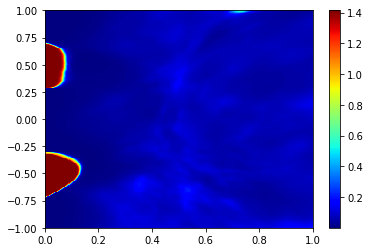

Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([-8.5672e-06,  7.3019e-06], device='cuda:0', grad_fn=<SliceBackward0>) tensor(0.0577, device='cuda:0', grad_fn=<SelectBackward0>)
u side tensor(0.0577, device='cuda:0', grad_fn=<AddBackward0>)
insid tensor(187.8806, device='cuda:0', grad_fn=<MulBackward0>)
bound tensor(1197.7649, device='cuda:0', grad_fn=<MulBackward0>)
Iter - 180 Train loss - 0.135106
Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([-8.4129e-06,  7.5626e-06], device='cuda:0', grad_fn=<SliceBackward0>) tensor(0.0500, device='cuda:0', grad_fn=<SelectBackward0>)
u side tensor(0.0500, device='cuda:0', grad_fn=<AddBackward0>)
insid tensor(207.2908, device='cuda:0', grad_fn=<MulBackward0>)
bound tensor(1181.4001, device='cuda:0', grad_fn=<MulBackward0>)
Iter - 181 Train loss - 0.135403
Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([-

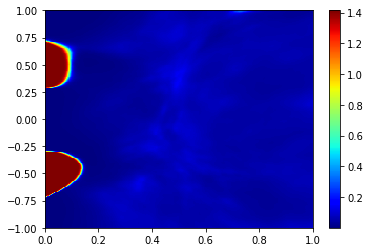

Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([-3.4142e-06,  1.7278e-06], device='cuda:0', grad_fn=<SliceBackward0>) tensor(0.0455, device='cuda:0', grad_fn=<SelectBackward0>)
u side tensor(0.0455, device='cuda:0', grad_fn=<AddBackward0>)
insid tensor(249.0754, device='cuda:0', grad_fn=<MulBackward0>)
bound tensor(1025.2095, device='cuda:0', grad_fn=<MulBackward0>)
Iter - 190 Train loss - 0.124248
Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([-4.7050e-06,  2.8381e-06], device='cuda:0', grad_fn=<SliceBackward0>) tensor(0.0464, device='cuda:0', grad_fn=<SelectBackward0>)
u side tensor(0.0464, device='cuda:0', grad_fn=<AddBackward0>)
insid tensor(239.7273, device='cuda:0', grad_fn=<MulBackward0>)
bound tensor(1002.3134, device='cuda:0', grad_fn=<MulBackward0>)
Iter - 191 Train loss - 0.121104
Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([-

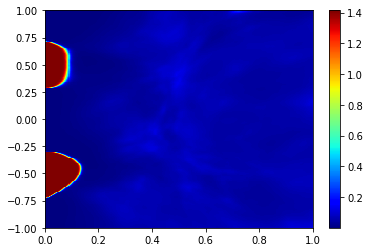

Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([-1.0307e-06,  2.6873e-07], device='cuda:0', grad_fn=<SliceBackward0>) tensor(0.0336, device='cuda:0', grad_fn=<SelectBackward0>)
u side tensor(0.0336, device='cuda:0', grad_fn=<AddBackward0>)
insid tensor(229.9973, device='cuda:0', grad_fn=<MulBackward0>)
bound tensor(1039.2670, device='cuda:0', grad_fn=<MulBackward0>)
Iter - 200 Train loss - 0.123758
Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([ 8.7696e-07, -8.3035e-07], device='cuda:0', grad_fn=<SliceBackward0>) tensor(0.0336, device='cuda:0', grad_fn=<SelectBackward0>)
u side tensor(0.0336, device='cuda:0', grad_fn=<AddBackward0>)
insid tensor(224.8919, device='cuda:0', grad_fn=<MulBackward0>)
bound tensor(1000.0989, device='cuda:0', grad_fn=<MulBackward0>)
Iter - 201 Train loss - 0.119441
Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([-

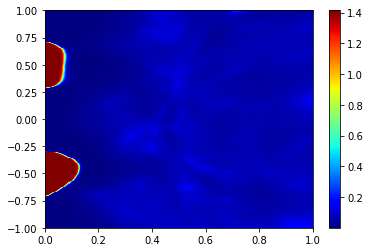

Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([-3.8607e-07,  9.6450e-07], device='cuda:0', grad_fn=<SliceBackward0>) tensor(0.0342, device='cuda:0', grad_fn=<SelectBackward0>)
u side tensor(0.0342, device='cuda:0', grad_fn=<AddBackward0>)
insid tensor(202.0379, device='cuda:0', grad_fn=<MulBackward0>)
bound tensor(1024.5293, device='cuda:0', grad_fn=<MulBackward0>)
Iter - 210 Train loss - 0.119595
Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([-1.2846e-06,  2.4637e-06], device='cuda:0', grad_fn=<SliceBackward0>) tensor(0.0318, device='cuda:0', grad_fn=<SelectBackward0>)
u side tensor(0.0318, device='cuda:0', grad_fn=<AddBackward0>)
insid tensor(193.6485, device='cuda:0', grad_fn=<MulBackward0>)
bound tensor(1083.6239, device='cuda:0', grad_fn=<MulBackward0>)
Iter - 211 Train loss - 0.124539
Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([-

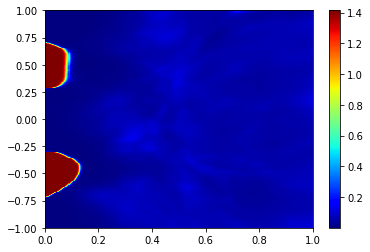

Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([-6.1180e-08, -8.4971e-07], device='cuda:0', grad_fn=<SliceBackward0>) tensor(0.0310, device='cuda:0', grad_fn=<SelectBackward0>)
u side tensor(0.0310, device='cuda:0', grad_fn=<AddBackward0>)
insid tensor(221.4003, device='cuda:0', grad_fn=<MulBackward0>)
bound tensor(1031.6229, device='cuda:0', grad_fn=<MulBackward0>)
Iter - 220 Train loss - 0.122175
Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([ 1.7369e-07, -9.7340e-08], device='cuda:0', grad_fn=<SliceBackward0>) tensor(0.0355, device='cuda:0', grad_fn=<SelectBackward0>)
u side tensor(0.0355, device='cuda:0', grad_fn=<AddBackward0>)
insid tensor(188.2973, device='cuda:0', grad_fn=<MulBackward0>)
bound tensor(1209.0442, device='cuda:0', grad_fn=<MulBackward0>)
Iter - 221 Train loss - 0.136246
Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([-

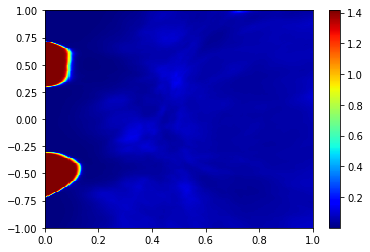

Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([-3.1747e-06,  2.4914e-06], device='cuda:0', grad_fn=<SliceBackward0>) tensor(0.0352, device='cuda:0', grad_fn=<SelectBackward0>)
u side tensor(0.0352, device='cuda:0', grad_fn=<AddBackward0>)
insid tensor(209.4262, device='cuda:0', grad_fn=<MulBackward0>)
bound tensor(1181.1112, device='cuda:0', grad_fn=<MulBackward0>)
Iter - 230 Train loss - 0.135583
Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([-2.7494e-06,  2.4257e-06], device='cuda:0', grad_fn=<SliceBackward0>) tensor(0.0333, device='cuda:0', grad_fn=<SelectBackward0>)
u side tensor(0.0333, device='cuda:0', grad_fn=<AddBackward0>)
insid tensor(229.7237, device='cuda:0', grad_fn=<MulBackward0>)
bound tensor(1075.1666, device='cuda:0', grad_fn=<MulBackward0>)
Iter - 231 Train loss - 0.127232
Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([-

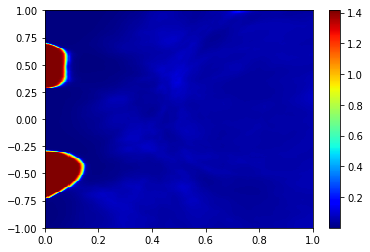

Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([ 1.0217e-06, -8.6129e-07], device='cuda:0', grad_fn=<SliceBackward0>) tensor(0.0313, device='cuda:0', grad_fn=<SelectBackward0>)
u side tensor(0.0313, device='cuda:0', grad_fn=<AddBackward0>)
insid tensor(221.7954, device='cuda:0', grad_fn=<MulBackward0>)
bound tensor(1196.9924, device='cuda:0', grad_fn=<MulBackward0>)
Iter - 240 Train loss - 0.138337
Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([1.0873e-06, 1.5720e-07], device='cuda:0', grad_fn=<SliceBackward0>) tensor(0.0327, device='cuda:0', grad_fn=<SelectBackward0>)
u side tensor(0.0327, device='cuda:0', grad_fn=<AddBackward0>)
insid tensor(228.8764, device='cuda:0', grad_fn=<MulBackward0>)
bound tensor(1067.7354, device='cuda:0', grad_fn=<MulBackward0>)
Iter - 241 Train loss - 0.126425
Iter - 1 
batch tensor([0.9701, 0.7719], device='cuda:0', grad_fn=<SliceBackward0>)
grad tensor([-1.

In [117]:
num_epochs = 250
optimizer = optim.Adam(model.parameters(), lr=5e-4, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-3, amsgrad=False)
train_losses, trained_model = train_model(trained_model, data_loader, num_epochs, mse_loss_f, mse_loss_h, optimizer)

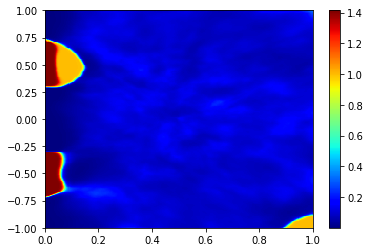

In [108]:
import numpy as np
import matplotlib.pyplot as plt

def plot_model_output(model,X_u_test,x0, z0):
    # coords = np.stack([X, Z], axis=-1)
    # print(coords[1,1,:])

    # Reshape coordinates to be compatible with the model
    # coords = coords.reshape(-1, 2)
    coords = X_u_test
    coords = torch.tensor(coords,dtype=torch.float).to(device)
    # coords = torch.nn.functional.normalize(coords + 1, p=2, dim=1, eps=1e-12, out=None).to(device)
    # print(coords.shape)
    # print(coords)
    # Run the coordinates through the model
    output = model(coords)
    # print(output.shape)
    Uoutput = output[:,0]
    Voutput = output[:,1]
    # print(Voutput.shape)
    # Reshape the output to match the original shape of the indices
    Uoutput = Uoutput.reshape(256, 256)
    Voutput = Voutput.reshape(256, 256)

    Uoutput = Uoutput.pow(2)
    Voutput = Voutput.pow(2)
    output = Uoutput + Voutput
    output = torch.sqrt(output).to('cpu')

    # Plot the output as an image
    plt.pcolor(z0, x0, output.detach().numpy(), cmap='jet')
    # plt.imshow(output.detach().numpy(), cmap='jet')
    plt.colorbar()
    plt.show()

plot_model_output(trained_model,X_u_test,x0, z0)


In [109]:
coords = np.stack([X, Z], axis=-1)
# print(coords[0,:,:])

# # Reshape coordinates to be compatible with the model
# coords = coords.reshape(-1, 2)
coords = torch.tensor(coords,dtype=torch.float)
coords = torch.nn.functional.normalize(coords + 1, p=2, dim=1, eps=1e-12, out=None).to(device)
# print(coords.shape)
# print(coords)
# Run the coordinates through the model
output = model(coords[:,0,:])
print(output)

tensor([[0.4000, 0.1928],
        [0.2153, 0.1169],
        [0.1663, 0.1747],
        [0.0745, 0.1438],
        [0.4933, 0.3596],
        [0.1787, 0.1086],
        [0.6602, 0.3500],
        [0.1892, 0.0045],
        [0.1026, 0.1571],
        [0.1407, 0.0244],
        [0.1103, 0.1003],
        [0.1663, 0.1747],
        [0.7496, 0.0704],
        [0.8737, 0.0466],
        [0.1026, 0.1571],
        [0.2153, 0.1169],
        [0.7496, 0.0704],
        [0.7496, 0.0704],
        [0.1103, 0.1003],
        [0.4000, 0.1928],
        [0.4000, 0.1928],
        [0.1557, 0.0815],
        [0.1103, 0.1003],
        [0.2153, 0.1169],
        [0.1663, 0.1747],
        [0.7496, 0.0704],
        [0.3428, 0.9999],
        [0.1929, 0.1797],
        [0.1892, 0.0045],
        [0.0813, 0.0199],
        [0.1175, 0.0181],
        [0.2524, 0.2390],
        [0.1929, 0.1797],
        [0.1407, 0.0244],
        [0.1103, 0.1003],
        [0.6602, 0.3500],
        [0.3664, 0.0040],
        [0.2524, 0.2390],
        [0.1

### Part (b) -- 10%
Complete the `plot_learning_curve` function and plot the learning curve, include your plot in your PDF submission.

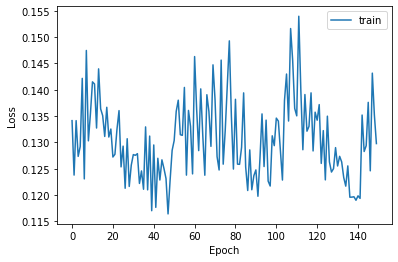

In [110]:
def plot_learning_curve(train_losses):
    """
    Plot the learning curve.
    """
    # Write your code here
    plt.plot(train_losses[100:], label='train')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


plot_learning_curve(train_losses)

## Question 4. Testing (15%)

### Part (a) -- 7%

Complete the function `test` and use it to print the test error of your model, separately for the test set. 

Do this by choosing the model architecture and hyperparameters that produces the best validation loss. 

In [111]:
def test(model, X_test_tensor):
                
  u_pred = model.forward(X_test_tensor)
        
  error_vec = ...  # TODO: complete this line. It should be relative L2 Norm of the error (Vector)
        
  u_pred = np.reshape(u_pred.detach().numpy(), (256,256), order='F') 
        
  return ... # TODO: complete what the function should return

### Part (b) -- 8%

We want to visualize how good your model is. Therefore, display the initial and boundary conditions data and the predicted data from the model output.


In [112]:
# TODO: your code goes here

**Discuss your results:**
